In [0]:
import numpy as np
import matplotlib.pyplot as plt
import h5py #Pythonic interface to the HDF5 binary data format.
import scipy
from PIL import Image
%matplotlib inline

In [0]:
def load_dataset():
    train_dataset = h5py.File('/dataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/dataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


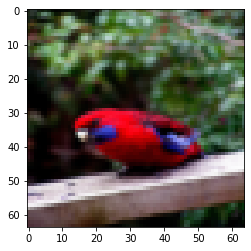

In [40]:
# Example of a picture
index = 35
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [41]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [42]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [43]:
# Preprocessing
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

len(train_set_x)

12288

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

The main steps for building a Neural Network are:

- Define the model structure (such as number of input features)
- Initialize the model's parameters
Loop:
  - Calculate current loss (forward propagation)
  - Calculate current gradient (backward propagation)
  - Update parameters (gradient descent)

In [0]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    
    return s

In [45]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [0]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [47]:

dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [0]:
# Forward and Backward propagation
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)              # compute activation
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)     # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [50]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = [0.49993523]
cost = 6.000064773192205


In [0]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code) 
        grads, cost = propagate(w=w, b=b, X=X, Y=Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [52]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = [1.55930492]
dw = [[0.90158428]
 [1.76250842]]
db = [0.43046207]


In [0]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    [print(x) for x in A]
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]

        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
            
        else:
            Y_prediction[0, i] = 0
            
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [54]:
print ("predictions = " + str(predict(w, b, X)))


[0.99987661 0.99999386]
predictions = [[1. 1.]]


In [0]:
# GRADED FUNCTION: model - Merge all functions to one

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [58]:

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 200, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
[0.83141586 0.82747879 0.85869237 0.82685874 0.7628477  0.56147366
 0.44197664 0.83634873 0.85276814 0.73906976 0.54044816 0.66811618
 0.71129825 0.75902797 0.20668694 0.81540037 0.2343112  0.75064914
 0.41166681 0.32990263 0.7324662  0.22008857 0.15704549 0.53908834
 0.79601037 0.74407443 0.66366929 0.23740104 0.36563787 0.89868301
 0.53056109 0.69947967 0.75983986 0.56263584 0.70471775 0.24153744
 0.40914623 0.80997093 0.66815744 0.21186954 0.60041301 0.81368675
 0.63466935 0.25673434 0.76499279 0.36460079 0.54183507 0.92782038
 0.58715957 0.35087757]
[0.50758923 0.32319403 0.776988   0.02112216 0.293458   0.44251047
 0.2130483  0.83094986 0.32277337 0.30634613 0.73344707 0.67539404
 0.55640044 0.81049328 0.44786603 0.34735985 0.32667864 0.25216421
 0.40205107 0.82490459 0.20556613 0.20624932 0.56363627 0.4985764
 0.74971312 0.66569481 0.25134991 0.63026125 0.35478475 0.48896505
 0.29175738 0.45601818 0.75978598 0.58

y = 1, you predicted that it is a "cat" picture.


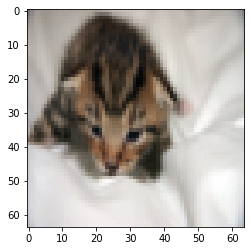

In [60]:
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")